In [48]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Prepare data

In [32]:
# Read in US data
df_us = pd.read_csv('../data/US_consolidated_df.csv')
df_us

# First difference inflation rate
df_us['infl_rate_diff'] = df_us['infl_rate'].diff()

# Drop na values due to differencing
df_us = df_us.dropna()

# Reorder columns
df_us = df_us[['date', 'infl_rate', 'infl_rate_diff', 'ppi', 'gdp_pct_change', 'int_3m', 'cons_conf', 'unm_rate']]

# Display df_us
df_us

,date,infl_rate,infl_rate_diff,ppi,gdp_pct_change,int_3m,cons_conf,unm_rate
1,2003-06-01,0.001093,0.002731,138.000,1.240696,1.04,100.50950,6.3
2,2003-07-01,0.003277,0.002183,137.700,2.244394,1.05,100.51170,6.2
3,2003-08-01,0.004355,0.001078,138.000,2.244394,1.08,100.42250,6.1
4,2003-09-01,0.003252,-0.001103,138.500,2.244394,1.08,100.38710,6.1
5,2003-10-01,-0.001080,-0.004333,139.300,1.777219,1.10,100.53510,6.0
...,...,...,...,...,...,...,...,...
257,2024-10-01,0.002265,-0.000027,253.081,1.173563,4.62,98.91297,4.1
258,2024-11-01,0.002805,0.000540,253.196,1.173563,4.53,98.91297,4.2
259,2024-12-01,0.003647,0.000842,253.406,1.173563,4.46,98.91297,4.1
260,2025-01-01,0.004669,0.001023,257.202,1.173563,4.33,98.91297,4.0


In [22]:
# Read in UK data
df_uk = pd.read_csv('../data/UK_consolidated_df.csv')

# Drop columns that are not needed
df_uk = df_uk[[
    'Date', 'CPI', 'PPI', '3mth Interest Rate', 'Composite Consumer Confidence',
    'Gross Domestic Product at market prices: Current price: Seasonally adjusted £m',
    'Unemployment rates (15 year old plus)'
]]

# Rename to match US data
df_uk = df_uk.rename(columns={
    'Date': 'date',
    'PPI': 'ppi',
    '3mth Interest Rate': 'int_3m',
    'Composite Consumer Confidence': 'cons_conf',
    'Gross Domestic Product at market prices: Current price: Seasonally adjusted £m': 'GDP',
    'Unemployment rates (15 year old plus)': 'unm_rate'
})

# Calculate the inflation rate
df_uk['infl_rate'] = df_uk['CPI'].pct_change() * 100

# Calculate GDP percentage change
df_uk['gdp_pct_change'] = df_uk['GDP'].pct_change() * 100

# First difference inflation rate
df_uk['infl_rate_diff'] = df_uk['infl_rate'].diff()

# Drop CPI and GDP columns
df_uk = df_uk.drop(columns=['CPI', 'GDP'])

# Drop rows with missing values due to percentage change and differencing
df_uk = df_uk.dropna()

# Reorder columns
df_uk = df_uk[['date', 'infl_rate', 'infl_rate_diff', 'ppi', 'gdp_pct_change', 'int_3m', 'cons_conf', 'unm_rate']]

# Display df_uk
df_uk

,date,infl_rate,infl_rate_diff,ppi,gdp_pct_change,int_3m,cons_conf,unm_rate
2,1986-03-01,0.103516,-0.312269,51.456058,0.377744,11.77679,99.74067,11.2
3,1986-04-01,1.034132,0.930616,51.612699,0.416643,10.57670,99.80801,11.3
4,1986-05-01,0.102350,-0.931782,51.377741,0.572017,10.26705,99.85727,11.3
5,1986-06-01,0.000000,-0.102350,51.456058,0.587722,9.82292,99.89935,11.3
6,1986-07-01,-0.306737,-0.306737,51.377741,0.565440,10.03805,99.93089,11.3
...,...,...,...,...,...,...,...,...
465,2024-10-01,0.599251,0.524288,136.488626,0.344718,4.75000,101.33200,4.4
466,2024-11-01,0.223380,-0.375870,136.488626,0.000000,4.68000,101.21320,4.4
467,2024-12-01,0.371471,0.148091,136.488626,0.000000,4.64000,101.12320,4.4
468,2025-01-01,0.000000,-0.371471,136.488626,0.000000,4.55000,101.08700,4.4


# First-Order Autoregressive Model

## Why use `infl_rate_diff` instead of `infl_rate`?

Using `infl_rate_diff` (the first difference of the inflation rate) instead of `infl_rate` is a common practice in time series analysis for the following reasons:

1. Stationarity:
    - Many time series, including inflation rates, exhibit trends or non-stationary behavior, meaning their statistical properties (mean, variance, etc.) change over time.
    - Differencing the series (e.g., calculating `infl_rate_diff`) helps remove trends and makes the series stationary, which is a key assumption for many statistical models, including autoregressive models.

2. Modeling Changes:
    - The first difference (`infl_rate_diff`) represents the change in the inflation rate from one period to the next. This is often more informative for understanding short-term dynamics and relationships between variables than the raw inflation rate.

3. Avoiding Spurious Relationships:
    - Non-stationary variables can lead to spurious regression results, where relationships appear significant due to shared trends rather than actual causal connections. Differencing helps mitigate this issue.

4. Focus on Dynamics:
    - Economic models often focus on how changes in variables (e.g., inflation rate changes) respond to other factors, rather than their absolute levels. Using `infl_rate_diff` aligns with this focus.

By using `infl_rate_diff`, we ensure that the data meets the assumptions of the statistical models and better captures the underlying dynamics of the inflation rate.

In [56]:
def adf_test(data, max_lag):
    adf = sm.tsa.adfuller(data, maxlag=max_lag)
    print(f'ADF Statistic: {adf[0]}')
    print(f'p-value: {adf[1]}')
    for key, value in adf[4].items():
        print('Critial Values:')
        print(f'   {key}, {value}')
    if adf[1] < 0.05:
        print('Reject the null hypothesis - data is stationary')
    else:
        print('Fail to reject the null hypothesis - data is non-stationary')

adf_test(df_uk['infl_rate'], 1)
print()
adf_test(df_uk['infl_rate_diff'], 0)
print()
adf_test(df_us['infl_rate'], 1)
print()
adf_test(df_us['infl_rate_diff'], 0)

ADF Statistic: -18.209951766910923
p-value: 2.3940982723230847e-30
Critial Values:
   1%, -3.4444305322234365
Critial Values:
   5%, -2.8677488864580885
Critial Values:
   10%, -2.5700770984781443
Reject the null hypothesis - data is stationary

ADF Statistic: -35.17819427923857
p-value: 0.0
Critial Values:
   1%, -3.4444305322234365
Critial Values:
   5%, -2.8677488864580885
Critial Values:
   10%, -2.5700770984781443
Reject the null hypothesis - data is stationary

ADF Statistic: -9.541520801403934
p-value: 2.718607623764859e-16
Critial Values:
   1%, -3.4558530692911504
Critial Values:
   5%, -2.872764881778665
Critial Values:
   10%, -2.572751643088207
Reject the null hypothesis - data is stationary

ADF Statistic: -18.029331245901464
p-value: 2.6794757786386174e-30
Critial Values:
   1%, -3.4557539868570775
Critial Values:
   5%, -2.8727214497041422
Critial Values:
   10%, -2.572728476331361
Reject the null hypothesis - data is stationary


## UK

                            OLS Regression Results                            
Dep. Variable:         infl_rate_diff   R-squared:                       0.206
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     120.4
Date:                Wed, 19 Mar 2025   Prob (F-statistic):           4.57e-25
Time:                        04:22:25   Log-Likelihood:                -263.05
No. Observations:                 467   AIC:                             530.1
Df Residuals:                     465   BIC:                             538.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0006    

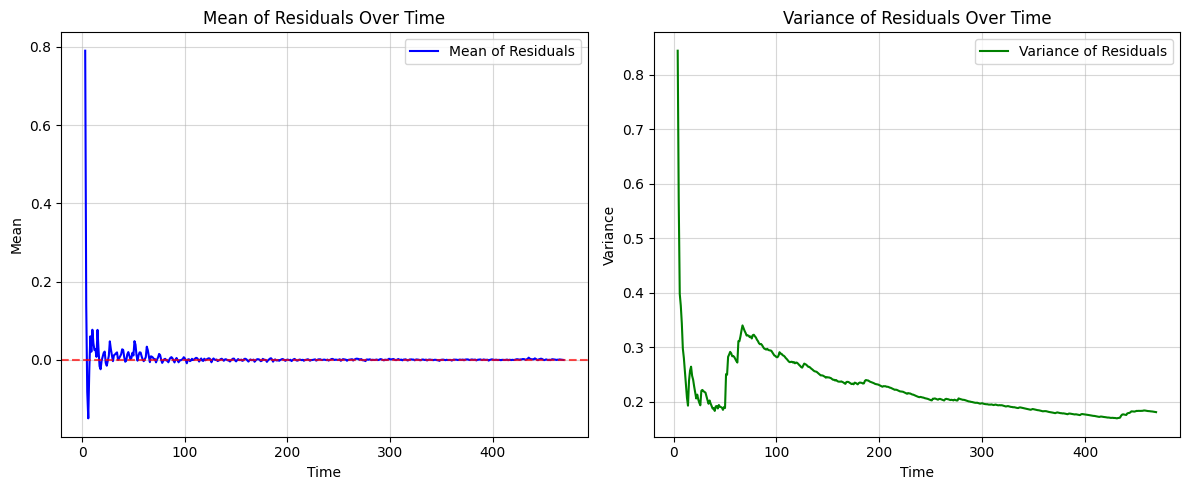

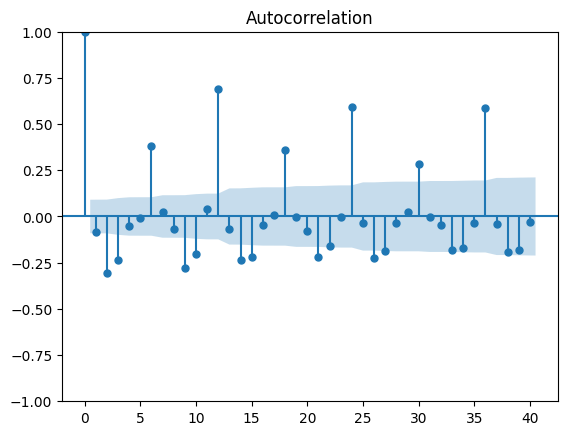

In [51]:
df_uk_ols = df_uk.copy()

# Create lagged variable for infl_rate_diff
df_uk_ols['infl_rate_diff_lag1'] = df_uk_ols['infl_rate_diff'].shift(1)

# Drop rows with NaN values due to lagging
df_uk_ols = df_uk_ols.dropna(subset=['infl_rate_diff', 'infl_rate_diff_lag1'])

# Define dependent and independent variables
X = df_uk_ols['infl_rate_diff_lag1']
y = df_uk_ols['infl_rate_diff']

# Add constant to the independent variable
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Print the summary of the regression
print(model.summary())

# Generate residuals
residuals = model.resid

# Compute moments (mean and variance) of residuals over time
mean_residuals = residuals.expanding().mean()
var_residuals = residuals.expanding().var()

# Plot the moments of residuals
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot mean of residuals
ax[0].plot(mean_residuals, label='Mean of Residuals', color='blue')
ax[0].axhline(0, color='red', linestyle='--', alpha=0.7)
ax[0].set_title('Mean of Residuals Over Time')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Mean')
ax[0].legend()
ax[0].grid(alpha=0.5)

# Plot variance of residuals
ax[1].plot(var_residuals, label='Variance of Residuals', color='green')
ax[1].set_title('Variance of Residuals Over Time')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Variance')
ax[1].legend()
ax[1].grid(alpha=0.5)

plt.tight_layout()
plt.show()

# Plot ACF of residuals
sm.graphics.tsa.plot_acf(residuals, lags=40)
plt.show()

## US

                            OLS Regression Results                            
Dep. Variable:         infl_rate_diff   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     3.448
Date:                Wed, 19 Mar 2025   Prob (F-statistic):             0.0645
Time:                        04:22:33   Log-Likelihood:                 1130.3
No. Observations:                 260   AIC:                            -2257.
Df Residuals:                     258   BIC:                            -2249.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                6.884e-06    

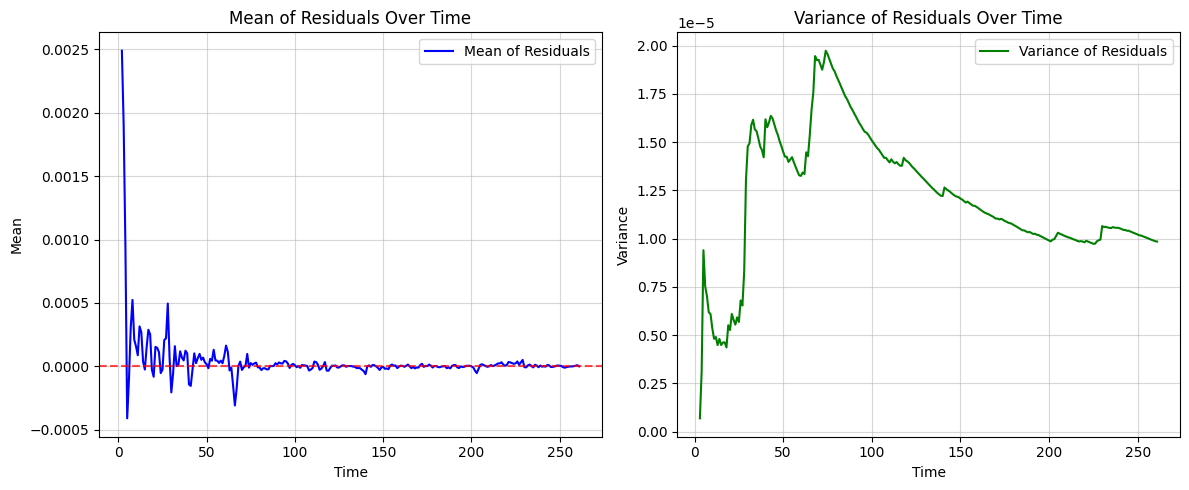

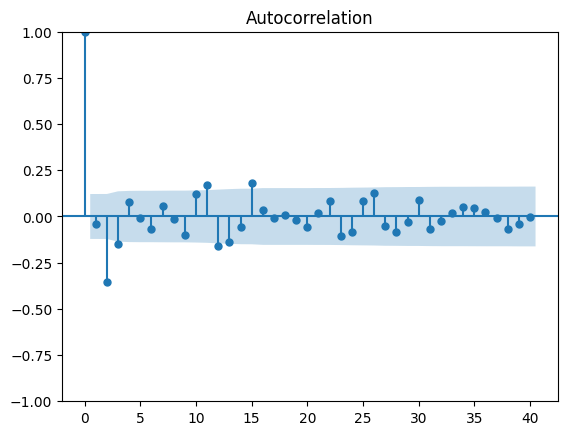

In [52]:
df_us_ols = df_us.copy()

# Create lagged variable for infl_rate_diff
df_us_ols['infl_rate_diff_lag1'] = df_us_ols['infl_rate_diff'].shift(1)

# Drop rows with NaN values due to lagging
df_us_ols = df_us_ols.dropna(subset=['infl_rate_diff', 'infl_rate_diff_lag1'])

# Define dependent and independent variables
X = df_us_ols['infl_rate_diff_lag1']
y = df_us_ols['infl_rate_diff']

# Add constant to the independent variable
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Print the summary of the regression
print(model.summary())

# Generate residuals
residuals = model.resid

# Compute moments (mean and variance) of residuals over time
mean_residuals = residuals.expanding().mean()
var_residuals = residuals.expanding().var()

# Plot the moments of residuals
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot mean of residuals
ax[0].plot(mean_residuals, label='Mean of Residuals', color='blue')
ax[0].axhline(0, color='red', linestyle='--', alpha=0.7)
ax[0].set_title('Mean of Residuals Over Time')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Mean')
ax[0].legend()
ax[0].grid(alpha=0.5)

# Plot variance of residuals
ax[1].plot(var_residuals, label='Variance of Residuals', color='green')
ax[1].set_title('Variance of Residuals Over Time')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Variance')
ax[1].legend()
ax[1].grid(alpha=0.5)

plt.tight_layout()
plt.show()

# Plot ACF of residuals
sm.graphics.tsa.plot_acf(residuals, lags=40)
plt.show()

## Is R² estimate relevant?

1. R² is designed for models with independent and identically distributed (IID) residuals.

2. In AR(1) models, the errors are autocorrelated as seen by significant spikes in the ACF plots of the residuals, meaning each error term depends on previous values, violating the IID assumption.

3. This can make R² misleading because a high R² doesn’t necessarily mean a good predictive fit in the presence of autocorrelation.

## Analysing moments

**Mean:**

A stationary model should have residuals with a mean close to 0 over time. 

If the mean deviates significantly from 0, it suggests that the model has a bias or is missing some key explanatory variables. For a well-specified model, the mean of residuals should hover around 0 without significant deviations. 

If the mean of residuals deviates significantly from 0, it suggests that the model is biased or that there are systematic patterns in the residuals that the model has not captured.

**Variance:**

A stationary model should have residuals with a constant variance over time (homoscedasticity). For a well-specified model, the variance of residuals should remain relatively constant over time. 

If the variance changes significantly, it indicates heteroscedasticity or instability in the model. 

If the variance of residuals increases or decreases significantly over time, it indicates heteroscedasticity (non-constant variance), which violates one of the key assumptions of OLS regression.

**UK:**

1. Mean hovers around 0
2. Variance relatively constant over time
Hence `infl_rate_diff` is indeed stationary in the UK.

**US:**

1. Mean hovers around 0
2. Variance not constant over time
Hence `infl_rate_diff` might not be stationary in the US.

# `p`-order Autoregressive Model

## How to determine lag order `p`?

To determine the lag order `p` in an AR(`p`) model, the following methods are commonly used:

1. **Information Criteria:**
    - Use criteria such as Akaike Information Criterion (AIC), Bayesian Information Criterion (BIC), or Hannan-Quinn Criterion (HQC).
    - Fit AR models with different lag orders and select the model with the lowest value of the chosen criterion.

2. **Partial Autocorrelation Function (PACF):**
    - Examine the PACF plot of the time series.
    - The lag at which the PACF cuts off (i.e., becomes insignificant) is a good candidate for `p`.

3. **Likelihood Ratio Test:**
    - Compare nested models (e.g., AR(`p`) vs. AR(`p-1`)) using a likelihood ratio test.
    - Choose the lag order where adding additional lags does not significantly improve the model fit.

4. **Automated Selection:**
    - Use statistical packages or libraries that implement automated lag selection (e.g., `statsmodels` in Python provides `AR` and `ARIMA` classes with lag selection options).

By combining these methods, you can determine the optimal lag order `p` for your AR(p) model.

## UK

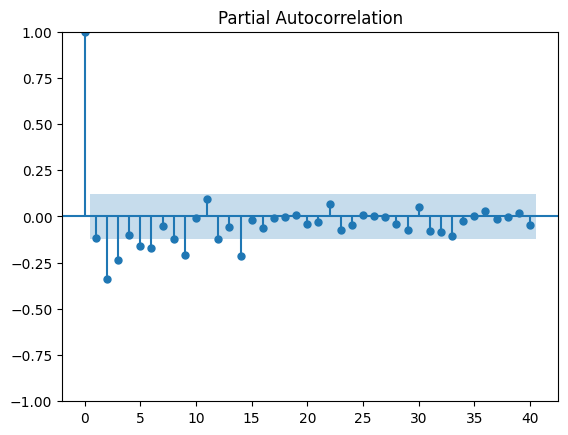

In [ ]:
# Plot PACF of infl_rate_diff
sm.graphics.tsa.plot_pacf(df_us_ols['infl_rate_diff'], lags=40)
plt.show()

## US

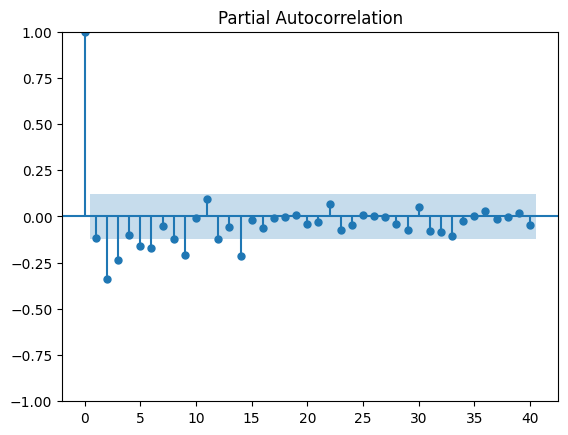

In [59]:
# Plot PACF of infl_rate_diff
sm.graphics.tsa.plot_pacf(df_us_ols['infl_rate_diff'], lags=40)
plt.show()